<a href="https://colab.research.google.com/github/RishabhSarkar/Box-Office-Prediction/blob/master/flight_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Prediction

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = pd.read_excel('Data_Train.xlsx')

In [0]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [0]:
data.shape

(10683, 11)

**Comment** : There are 10,683 flight records, and 11 features. <br>
- Airline: String (Flight company)
- Date of Journey (Date)
- Dep Time/ Arrival Time/ Duration (Flight time)
- Source/Destination/Route/ Total Stops (Flight path)
- Additional info
- Price (Target feature)
<br>

**According to me**: <br>
- Source and Destination is not required. It is covered in Route.
- The route needs to be converted into meaningful features.
- Total stops and Route are somewhat related
- Out of Dep Time/ Arrival Time and Duration, only two features are important. The third one is dependent on other two.
- Additional info is mostly a sparse feature

## Cleaning the data

### Step 1: Missing values

In [0]:
data.isnull().any()

Airline            False
Date_of_Journey    False
Source             False
Destination        False
Route               True
Dep_Time           False
Arrival_Time       False
Duration           False
Total_Stops         True
Additional_Info    False
Price              False
dtype: bool

**Comment** : We find that there are missing values in **Route** and **Total_Stops**

In [0]:
data.loc[data["Total_Stops"].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [0]:
#Checking what are the values that the Total_Stops take
data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [0]:
#Filling the missing value
data.loc[data["Total_Stops"].isnull(),"Total_Stops"] = "non-stop"

In [0]:
#Checking missing values again
data.isnull().any()

Airline            False
Date_of_Journey    False
Source             False
Destination        False
Route               True
Dep_Time           False
Arrival_Time       False
Duration           False
Total_Stops        False
Additional_Info    False
Price              False
dtype: bool

In [0]:
#Checking missing values in Route
data.loc[data["Route"].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,non-stop,No info,7480


In [0]:
#Checking what are the values that the Route take
data["Route"].value_counts()

DEL → BOM → COK                      2376
BLR → DEL                            1552
CCU → BOM → BLR                       979
CCU → BLR                             724
BOM → HYD                             621
                                     ... 
BOM → JLR → HYD                         1
BOM → GOI → HYD                         1
BLR → CCU → BBI → HYD → VGA → DEL       1
BOM → VNS → DEL → HYD                   1
BOM → JAI → DEL → HYD                   1
Name: Route, Length: 128, dtype: int64

In [0]:
#Filling the missing value
data.loc[data["Route"].isnull(),"Route"] = "DEL → COK"

## Step 2: Data Formatting

- Airline: Nominal Categorical
- Date_of_Journey: Numerical
- Source/Destination/Route: Nominal Categorical
- Dep Time/ Arrival Time/ Duration : Numerical
- Total_Stops: Ordinal Categorical
- Addditional info: Nominal Categorical

### 2.1 Mapping Ordinal feature: Total Stops

In [0]:
data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3492
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [0]:
stops_map = {"non-stop": 0,
             "1 stop": 1,
             "2 stops": 2,
             "3 stops": 3,
             "4 stops": 4}

In [0]:
data["Total_Stops"] = data["Total_Stops"].map(stops_map)

In [0]:
data["Total_Stops"].value_counts()

1    5625
0    3492
2    1520
3      45
4       1
Name: Total_Stops, dtype: int64

### 2.2 Making sense out of Source, Destination and Route features

In [0]:
route_df = data["Route"].str.split("→")

In [0]:
route_df

0                      [BLR ,  DEL]
1        [CCU ,  IXR ,  BBI ,  BLR]
2        [DEL ,  LKO ,  BOM ,  COK]
3               [CCU ,  NAG ,  BLR]
4               [BLR ,  NAG ,  DEL]
                    ...            
10678                  [CCU ,  BLR]
10679                  [CCU ,  BLR]
10680                  [BLR ,  DEL]
10681                  [BLR ,  DEL]
10682    [DEL ,  GOI ,  BOM ,  COK]
Name: Route, Length: 10683, dtype: object

In [0]:
route_df[100][1:-1]

[' BOM ']

**Comment**: Woahh! You can see how it worked as desired! <br>
You can find str.split() function in pandas here. <br>

In [0]:
route_df.head()

0                  [BLR ,  DEL]
1    [CCU ,  IXR ,  BBI ,  BLR]
2    [DEL ,  LKO ,  BOM ,  COK]
3           [CCU ,  NAG ,  BLR]
4           [BLR ,  NAG ,  DEL]
Name: Route, dtype: object

In [0]:
for index in data.index:
    data.loc[index, "Source"] = route_df[index][0].strip()
    data.loc[index, "Destination"] = route_df[index][-1].strip()
    del route_df[index][0]
    del route_df[index][-1]

In [0]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,BLR,DEL,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897
1,Air India,1/05/2019,CCU,BLR,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662
2,Jet Airways,9/06/2019,DEL,COK,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882
3,IndiGo,12/05/2019,CCU,BLR,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218
4,IndiGo,01/03/2019,BLR,DEL,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302


In [0]:
route_df.head()

0                []
1    [ IXR ,  BBI ]
2    [ LKO ,  BOM ]
3           [ NAG ]
4           [ NAG ]
Name: Route, dtype: object

In [0]:
route_df = route_df.apply(pd.Series)


In [0]:
route_df.rename({0:'Stop_1', 1:'Stop_2', 2:'Stop_3', 3:'Stop_4'}, axis = 'columns', inplace = True)

In [0]:
route_df.head()

,Stop_1,Stop_2,Stop_3,Stop_4
0,NaN,NaN,NaN,NaN
1,IXR,BBI,NaN,NaN
2,LKO,BOM,NaN,NaN
3,NAG,NaN,NaN,NaN
4,NAG,NaN,NaN,NaN


In [0]:
data.drop(labels=['Route'], axis= 'columns', inplace=True)

In [0]:
new_data = pd.concat([data, route_df], axis =1)

In [0]:
new_data.head()

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,24/03/2019,BLR,DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,1/05/2019,CCU,BLR,05:50,13:15,7h 25m,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,9/06/2019,DEL,COK,09:25,04:25 10 Jun,19h,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,12/05/2019,CCU,BLR,18:05,23:30,5h 25m,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,01/03/2019,BLR,DEL,16:50,21:35,4h 45m,1,No info,13302,NAG,NaN,NaN,NaN


### Comment: Source and Destination are Important Features than Intermediate Stops, hence kept them as seperate features.

### 2.3 Making sense out of Dep_time, Arrival_Time and Duration (One of the toughest task)

**Comment**: One of these features is redundant.

In [0]:
new_data["Dep_Time"]

0        22:20
1        05:50
2        09:25
3        18:05
4        16:50
         ...  
10678    19:55
10679    20:45
10680    08:20
10681    11:30
10682    10:55
Name: Dep_Time, Length: 10683, dtype: object

In [0]:
new_data["Arrival_Time"]

0        01:10 22 Mar
1               13:15
2        04:25 10 Jun
3               23:30
4               21:35
             ...     
10678           22:25
10679           23:20
10680           11:20
10681           14:10
10682           19:15
Name: Arrival_Time, Length: 10683, dtype: object

In [0]:
new_data["Duration"]

0        2h 50m
1        7h 25m
2           19h
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680        3h
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10683, dtype: object

**Comment: As we can see,**
- Departure Time and Duration ae well formatted.
- However, Arrival Time is not well formatted. It would take a lot of time to clean it to make it usable.

In [0]:
#Converting Departure Time and Duration into datetime format
new_data["Dep_Time"] = pd.to_datetime(new_data["Date_of_Journey"]+ ' ' + new_data["Dep_Time"])

In [0]:
new_data["Dep_Time"]

0       2019-03-24 22:20:00
1       2019-01-05 05:50:00
2       2019-09-06 09:25:00
3       2019-12-05 18:05:00
4       2019-01-03 16:50:00
                ...        
10678   2019-09-04 19:55:00
10679   2019-04-27 20:45:00
10680   2019-04-27 08:20:00
10681   2019-01-03 11:30:00
10682   2019-09-05 10:55:00
Name: Dep_Time, Length: 10683, dtype: datetime64[ns]

In [0]:
new_data.drop(labels=["Date_of_Journey", "Arrival_Time"], axis= 'columns', inplace = True)

In [0]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Duration,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,2h 50m,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,7h 25m,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,19h,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,5h 25m,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,4h 45m,1,No info,13302,NAG,NaN,NaN,NaN


In [0]:
#TODO: Convert Duration to proper datetime format using regex and datetime functions

#TODO: Check contents of Additional_Info

#TODO: Seperate Price (y) and reemaing data (X)

#TODO: One Hot Encode these features: 'Airline', 'Additional_Info', 'Stop_<all>'

#Then the data will be ready to be used in any Regression model.

In [0]:
#Finding all numbers in a string
import re
duration_series = new_data["Duration"].str.findall(r'\d+')

In [0]:
duration_series

0        [2, 50]
1        [7, 25]
2           [19]
3        [5, 25]
4        [4, 45]
          ...   
10678    [2, 30]
10679    [2, 35]
10680        [3]
10681    [2, 40]
10682    [8, 20]
Name: Duration, Length: 10683, dtype: object

In [0]:
from datetime import datetime
from datetime import timedelta
for i, duration_list in enumerate(duration_series.values):
    hours = int(duration_list[0])
    if len(duration_list)==1:
        mins = 0
    else:
        mins = int(duration_list[1])
        
    new_data.loc[i, "Duration"] = 60*hours + mins

In [0]:
new_data.rename(columns={"Duration": "Minutes"}, inplace = True)

In [0]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,170,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,445,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,1140,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,325,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,285,1,No info,13302,NAG,NaN,NaN,NaN


**Comment**: Wooh! The data looks cleaner

### 2.4 Checking Additional_Info

In [0]:
new_data["Additional_Info"].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

In [0]:
new_data.loc[new_data["Additional_Info"]=="No Info", "Additional_Info"] = "No info"

# Visaulizations and Plottings

### Describing the features

In [0]:
new_data.describe()

,Minutes,Total_Stops,Price
count,10683.000000,10683.000000,10683.000000
mean,643.120846,0.824113,9087.064121
std,507.835322,0.675244,4611.359167
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5277.000000
50%,520.000000,1.000000,8372.000000
75%,930.000000,1.000000,12373.000000
max,2860.000000,4.000000,79512.000000


**Comments**: These are the only numerical features in our dataset

## Plotting Numerical features
It's easier to visualize numerical features

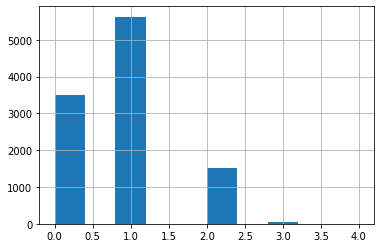

In [0]:
new_data["Total_Stops"].hist()

**NOTE**
- **Numerical** : Line plot
- **Nominal categorical** : Bar Plot
- **Ordinal Categorical**: Histogram

So, you can figure out, why I plotted a histogram for the Total_Stops feature.

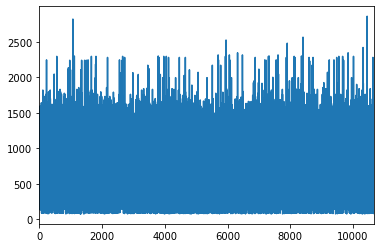

In [0]:
new_data["Minutes"].plot()

**Comments**: As we can see, the plot for Minutes is highly noisy. <br>
So, we should try to create bins and plot it to de-noise it. <br>
Therefore, let us try Histogram (**Default bins are 10**)

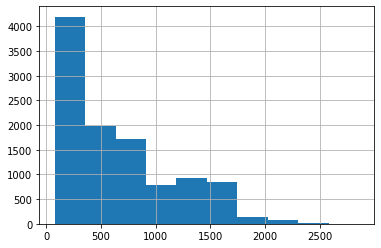

In [0]:
new_data["Minutes"].hist()

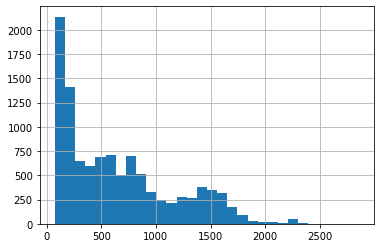

In [0]:
#Less bins => More information lost
#So let us try to increase bins
new_data["Minutes"].hist(bins=30)

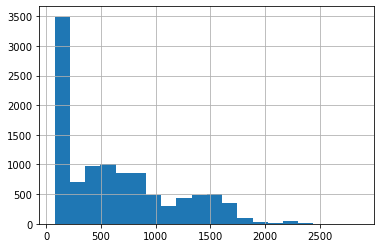

In [0]:
new_data["Minutes"].hist(bins=20)

**Minutes feature is highly right skewed with average at 520 minutes**

## Plotting Categorical Features

### Plotting Airline

In [0]:
new_data.groupby('Airline')['Price'].mean()

Airline
Air Asia                              5590.260188
Air India                             9611.210616
GoAir                                 5861.056701
IndiGo                                5673.682903
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
SpiceJet                              4338.284841
Trujet                                4140.000000
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Name: Price, dtype: float64

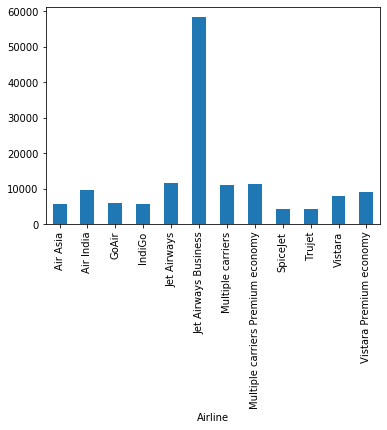

In [0]:
airline_grouped = new_data.groupby('Airline')['Price'].mean()

airline_grouped.plot.bar()

**Comments**: Jey Airaways Business has an extremely high price. <br>
In airlines feature, Jet Airways Buisness is highly determining of the price of flight

In [0]:
#Plotting again, without Jet Airways Business

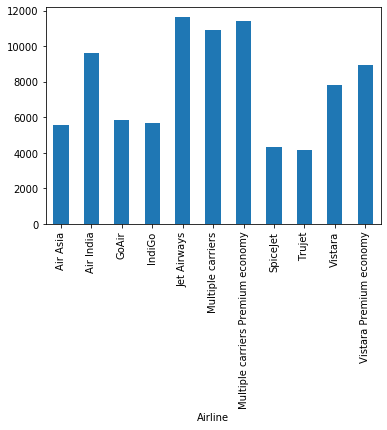

In [0]:
airlines_excluded_grouped = airline_grouped.drop(['Jet Airways Business'])
airlines_excluded_grouped.plot.bar()

**Comment**: Not much can be inferred.

### Checking Prices Monthly

In [0]:
new_data['Dep_Time'] = pd.to_datetime(new_data['Dep_Time'])

In [0]:
new_data.groupby(new_data["Dep_Time"].dt.month)["Price"].mean()

Dep_Time
1     10492.642791
3      8433.839891
4      5230.860849
5      9361.077628
6      9214.964905
9      9551.474395
12     9110.774295
Name: Price, dtype: float64

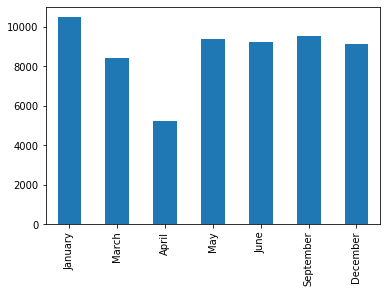

In [0]:
month_average = new_data.groupby(new_data["Dep_Time"].dt.month)["Price"].mean()
month_average.index = ["January", "March", "April", "May", "June", "September", "December"]
month_average.plot.bar()

**Comments**: Prices dipped in **April**. Highest in **January** <br>
**IMPORTANT: No data given for February, June, July, August, October and November**

### Is there a relation between the Day of the ticket booked?

In [0]:
new_data.groupby(new_data["Dep_Time"].dt.weekday_name)["Price"].mean()

Dep_Time
Friday       8556.502220
Monday       9721.101945
Saturday     8894.375727
Sunday       9556.827684
Thursday     9805.088646
Tuesday      8960.452265
Wednesday    7996.290807
Name: Price, dtype: float64

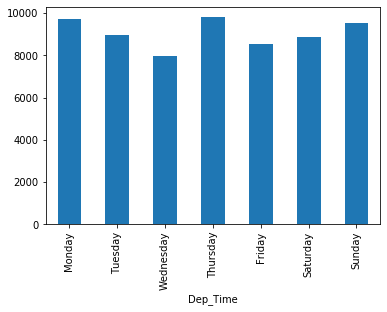

In [0]:
days = ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_grouped = new_data.groupby(new_data["Dep_Time"].dt.weekday_name)["Price"].mean().reindex(days)
weekday_grouped.plot.bar()

**Comments**: <br>
Sunday, Monday and Thursday one of the highest. <br>
Prices dip from Monday to Wednesday and increases from Friday to Sunday

## Is there any relation between the day of the month the ticket is booked?

In [0]:
new_data.groupby(new_data["Dep_Time"].dt.day)["Price"].mean()

Dep_Time
3     13294.191036
4      6120.395420
5      8778.854167
6      9305.855956
15     8127.810976
18     8671.573317
21     8351.760576
24     8399.446768
27     8204.128319
Name: Price, dtype: float64

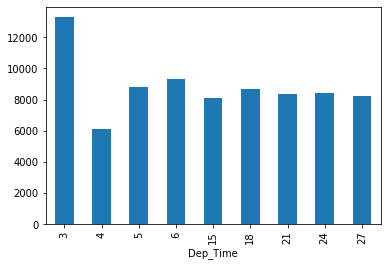

In [0]:
day_grouped = new_data.groupby(new_data["Dep_Time"].dt.day)["Price"].mean()
day_grouped.plot.bar()

## Is there a relation between the time of the day the ticket is booked?

In [0]:
time_grouped = new_data.groupby(new_data["Dep_Time"].dt.hour)['Price'].mean()

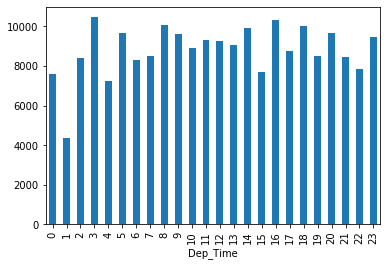

In [0]:
time_grouped.plot.bar()

**Comments**: <br>
Only 9 days data from 6 months given <br>
The tickets are booked highest on 3rd

## Can we see any relation with Additional Info?

In [0]:
new_data.groupby('Additional_Info')['Price'].mean()

Additional_Info
1 Long layover                  22109.631579
1 Short layover                 26743.000000
2 Long layover                  26480.000000
Business class                  56811.250000
Change airports                 16800.714286
In-flight meal not included      9471.834511
No check-in baggage included     3645.156250
No info                          9140.926090
Red-eye flight                  10873.000000
Name: Price, dtype: float64

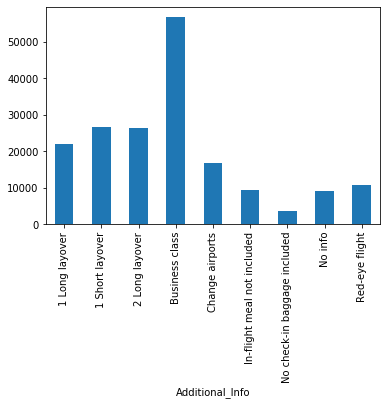

In [0]:
info_grouped = new_data.groupby('Additional_Info')['Price'].mean()
info_grouped.plot.bar()

**Comments**: Busines class plays an important role.

## Does the minutes of Flight affect the price?

In [0]:
new_data["Minutes"].values.max()

2860

In [0]:
new_data["Minutes"].values.min()

75

In [0]:
NUM_BINS = (2860 - 75)//300
bins = np.linspace(75,2860,NUM_BINS) #Bins in the interval of 5 hours (300 mins)
hours_df = pd.cut(new_data['Minutes'], bins)

In [0]:
hours_df

0           (75.0, 423.125]
1         (423.125, 771.25]
2        (1119.375, 1467.5]
3           (75.0, 423.125]
4           (75.0, 423.125]
                ...        
10678       (75.0, 423.125]
10679       (75.0, 423.125]
10680       (75.0, 423.125]
10681       (75.0, 423.125]
10682     (423.125, 771.25]
Name: Minutes, Length: 10683, dtype: category
Categories (8, interval[float64]): [(75.0, 423.125] < (423.125, 771.25] < (771.25, 1119.375] < (1119.375, 1467.5] < (1467.5, 1815.625] < (1815.625, 2163.75] < (2163.75, 2511.875] < (2511.875, 2860.0]]

In [0]:
new_data.groupby(hours_df)['Price'].mean()

Minutes
(75.0, 423.125]         6054.689157
(423.125, 771.25]      11134.966219
(771.25, 1119.375]     11035.499331
(1119.375, 1467.5]     12055.007380
(1467.5, 1815.625]     11617.182119
(1815.625, 2163.75]    12496.873563
(2163.75, 2511.875]    12127.000000
(2511.875, 2860.0]     16310.250000
Name: Price, dtype: float64

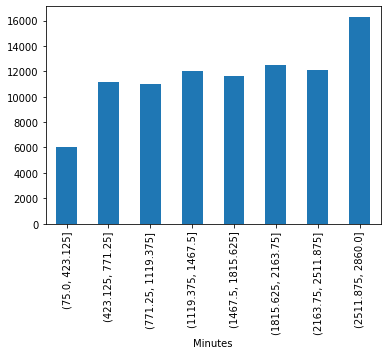

In [0]:
new_data.groupby(hours_df)['Price'].mean().plot.bar()

**Comments** The price generally increases with increase in minutes

In [0]:
new_data[["Minutes", "Price"]].corr()

,Minutes,Price
Minutes,1.000000,0.506495
Price,0.506495,1.000000


**Comment**: The minutes and price has a correlation of 0.5

## Most Important: Does Source and Destination matters?

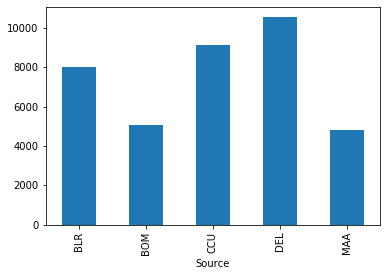

In [0]:
source_grouped = new_data.groupby('Source')["Price"].mean()
source_grouped.plot.bar()

**Comment**: Flights leaving from Delhi and CCU have a higher rate in general

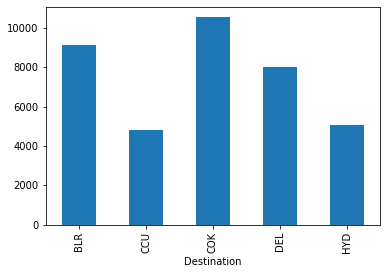

In [0]:
dest_grouped = new_data.groupby('Destination')["Price"].mean()
dest_grouped.plot.bar()

## Last Data Formatting: Splitting Dep_Time into Hour, Day, Month

In [0]:
new_data.head()

,Airline,Source,Destination,Dep_Time,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4
0,IndiGo,BLR,DEL,2019-03-24 22:20:00,170,0,No info,3897,NaN,NaN,NaN,NaN
1,Air India,CCU,BLR,2019-01-05 05:50:00,445,2,No info,7662,IXR,BBI,NaN,NaN
2,Jet Airways,DEL,COK,2019-09-06 09:25:00,1140,2,No info,13882,LKO,BOM,NaN,NaN
3,IndiGo,CCU,BLR,2019-12-05 18:05:00,325,1,No info,6218,NAG,NaN,NaN,NaN
4,IndiGo,BLR,DEL,2019-01-03 16:50:00,285,1,No info,13302,NAG,NaN,NaN,NaN


**Comment**: Now, we will split Dep_Time into different columns as: Day, Month and Hour

- The **Day (Mon, Tue, Wed, etc)** features affects the prices (graph above)
- The **Month (Jan, March, etc)** feature also affects the prices

In [0]:
#Creating a new dataframe
temp_df = new_data.copy()
temp_df["Dep_Day"] = new_data["Dep_Time"].dt.weekday.values
temp_df["Dep_Month"] = new_data["Dep_Time"].dt.month.values
temp_df["Dep_Hour"] = new_data["Dep_Time"].dt.hour.values
temp_df.drop(labels=["Dep_Time"], axis = 'columns', inplace = True)
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day,Dep_Month,Dep_Hour
0,IndiGo,BLR,DEL,170,0,No info,3897,NaN,NaN,NaN,NaN,6,3,22
1,Air India,CCU,BLR,445,2,No info,7662,IXR,BBI,NaN,NaN,5,1,5
2,Jet Airways,DEL,COK,1140,2,No info,13882,LKO,BOM,NaN,NaN,4,9,9
3,IndiGo,CCU,BLR,325,1,No info,6218,NAG,NaN,NaN,NaN,3,12,18
4,IndiGo,BLR,DEL,285,1,No info,13302,NAG,NaN,NaN,NaN,3,1,16


In [0]:
temp_df.loc[temp_df["Additional_Info"] == "No info", "Additional_Info"] = np.nan

In [0]:
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day,Dep_Month,Dep_Hour
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,6,3,22
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,5,1,5
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,4,9,9
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,3,12,18
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,3,1,16


## Very Important: Days/Weekday are NOT Categorical nor Numerical
They are cyclic statistics

In [0]:
temp_df["Dep_Day"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.day.values/7)
temp_df["Dep_Hour"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.hour.values/24)
temp_df["Dep_Month"] = np.sin(2*np.pi*new_data["Dep_Time"].dt.month.values/12)
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day,Dep_Month,Dep_Hour
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


In [0]:
temp_df.rename({'Dep_Day':'Dep_Day_sine', 'Dep_Hour': 'Dep_Hour_sine', 'Dep_Month': 'Dep_Month_sine'},
               axis = 'columns', inplace = True)

In [0]:
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


# Model Building (The Meat of the Problem)

### One- Hot Encoding

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
categorical_features = ['Airline', 'Source', 'Destination','Additional_Info', 'Stop_1', 
                                            'Stop_2', 'Stop_3', 'Stop_4']

In [0]:
temp_df.head()

,Airline,Source,Destination,Minutes,Total_Stops,Additional_Info,Price,Stop_1,Stop_2,Stop_3,Stop_4,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine
0,IndiGo,BLR,DEL,170,0,NaN,3897,NaN,NaN,NaN,NaN,0.433884,1.000000e+00,-0.500000
1,Air India,CCU,BLR,445,2,NaN,7662,IXR,BBI,NaN,NaN,-0.974928,5.000000e-01,0.965926
2,Jet Airways,DEL,COK,1140,2,NaN,13882,LKO,BOM,NaN,NaN,-0.781831,-1.000000e+00,0.707107
3,IndiGo,CCU,BLR,325,1,NaN,6218,NAG,NaN,NaN,NaN,-0.974928,-2.449294e-16,-1.000000
4,IndiGo,BLR,DEL,285,1,NaN,13302,NAG,NaN,NaN,NaN,0.433884,5.000000e-01,-0.866025


In [0]:
one_hot = pd.get_dummies(temp_df[categorical_features])

In [0]:
one_hot.head()

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Stop_3_ AMD,Stop_3_ BBI,Stop_3_ BHO,Stop_3_ BOM,Stop_3_ DEL,Stop_3_ GWL,Stop_3_ HYD,Stop_3_ NAG,Stop_3_ TRV,Stop_4_ VGA
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
one_hot.shape

(10683, 105)

In [0]:
one_hot_df = pd.concat([temp_df, one_hot], axis = 1)

In [0]:
one_hot_df.drop(labels = categorical_features, axis = 'columns', inplace = True)

In [0]:
one_hot_df.head()

,Minutes,Total_Stops,Price,Dep_Day_sine,Dep_Month_sine,Dep_Hour_sine,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Stop_3_ AMD,Stop_3_ BBI,Stop_3_ BHO,Stop_3_ BOM,Stop_3_ DEL,Stop_3_ GWL,Stop_3_ HYD,Stop_3_ NAG,Stop_3_ TRV,Stop_4_ VGA
0,170,0,3897,0.433884,1.000000e+00,-0.500000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,445,2,7662,-0.974928,5.000000e-01,0.965926,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1140,2,13882,-0.781831,-1.000000e+00,0.707107,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,325,1,6218,-0.974928,-2.449294e-16,-1.000000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,285,1,13302,0.433884,5.000000e-01,-0.866025,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Training and Validation Set

In [0]:
y = one_hot_df["Price"].values
X = one_hot_df.drop(labels= ['Price'], axis = 'columns').values

In [0]:
X.shape, y.shape

((10683, 110), (10683,))

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 2)

In [0]:
X_train.shape, y_train.shape

((8012, 110), (8012,))

In [0]:
X_val.shape, y_val.shape

((2671, 110), (2671,))

## Rescaing

In [0]:
#Rescaling Minutes
X_train[:,0] /= X_train[:,0].max()
X_val[:,0] /= X_val[:,0].max()

## Making your own scorer: MSLE

In [0]:
from sklearn.metrics import make_scorer

In [0]:
import math
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [0]:
def rmsle_score(y, y_pred):
    return 1 - rmsle(y, y_pred)

In [0]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better = True)

## Model 1: RandomForestRegression

**NOTE: First we compare the scores with the default settings**

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rfg = RandomForestRegressor()

In [0]:
rfg.fit(X_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
y_pred = rfg.predict(X_val)

In [0]:
1 - rmsle(y_val, y_pred)

0.8029106460113965

In [0]:
1 - rmsle(rfg.predict(X_train), y_train)

0.8989090812819678

## Model 2: Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
lnr = LinearRegression()

In [0]:
lnr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = lnr.predict(X_val)

In [0]:
1 - rmsle(y_val, y_pred)

-0.25504058234562343

In [0]:
1 - rmsle(lnr.predict(X_train), y_train)

0.7542119229930828

## Model3: Ridge Regression

In [0]:
from sklearn.linear_model import Ridge

In [0]:
rdg = Ridge()

In [0]:
rdg.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
1 - rmsle(rdg.predict(X_val), y_val)

0.7500147953645029

In [0]:
1 - rmsle(rdg.predict(X_train), y_train)

0.7538386044936323

## Model4: Lasso

In [0]:
from sklearn.linear_model import Lasso

In [0]:
lasso = Lasso()

In [0]:
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
1 - rmsle(lasso.predict(X_val), y_val)

0.7504583861614842

In [0]:
1 - rmsle(lasso.predict(X_train), y_train)

0.7536323300302147

## Model5: SVM Regression

In [0]:
from sklearn.svm import SVR

In [0]:
svr = SVR()

In [0]:
svr.fit(X_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
1 - rmsle(svr.predict(X_val), y_val)

0.49690598770460115

In [0]:
1 - rmsle(svr.predict(X_train), y_train)

0.49019738124669476

## Let's explore RandomForestRegressor a bit

In [0]:
RFnew = RandomForestRegressor(n_estimators=20)

In [0]:
RFnew.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
1 - rmsle(RFnew.predict(X_val), y_val)

0.8074519732509694

In [0]:
1 - rmsle(RFnew.predict(X_train), y_train)

0.9022468580107086

In [0]:
RFnew = RandomForestRegressor(n_estimators=100, max_depth = 20,min_samples_split = 15, max_features='sqrt',
                              min_samples_leaf = 1)
RFnew.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
1 - rmsle(RFnew.predict(X_val), y_val)

0.813276137359894

In [0]:
1 - rmsle(RFnew.predict(X_train), y_train)

0.8329802753559952

#### NOTE: The above model was come up with a lot of trials. (Overfits very less)

## Performing Grid Search

In [0]:
param_rf = {'n_estimators':[80,110,140,170], 'max_depth':[17,18,19,20],
            'min_samples_split':[5,10,20,30,50,80], 'min_samples_leaf':[1,2,3],
            'max_features':['log2','sqrt','auto']}

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
gridRF = RandomizedSearchCV(estimator = RFnew, param_distributions = param_rf, scoring = rmsle_scorer, n_iter = 40)

In [0]:
gridRF.fit(X_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=20,
                                                   max_features='sqrt',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=15,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [0]:
gridRF.best_params_

{'n_estimators': 140,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 18}

In [0]:
gridRF.score(X_train, y_train)

0.8692245490178301

In [0]:
gridRF.score(X_val, y_val)

0.8219639575982214

In [0]:
gridRF.best_score_

0.8143678906453817